In [1]:
from ultralytics import YOLO
import cv2
import time
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YOLO('yolov8l.pt')
model.to(device)


/home/kushal/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_r

# Testing for One Image

In [7]:
results = model("../data/img/01235.png",save=True)

FileNotFoundError: ../data/img/01235.png does not exist

# Code Used to Run for all images
- The following code is also used to store the relevant data of object detection to be used for further analysis

In [ ]:
import json

json_file_path = "data/train.jsonl"


image_data = {}

with open(json_file_path, 'r') as f:
    for line in f:
        entry = json.loads(line)

        image_id = int(entry['id'])
        image_path = "data/"+entry['img']
        label = int(entry['label'])
        text = entry['text']

        image_data[image_id] = {
            'image_id' : image_id,
            'image_path': image_path,
            'label': label,
            'text': text
        }
object_detection_results={}
i=int(0)
for key,elem in image_data.items():
    # print(elem)
    # if (elem['image_path']):
    if (i==100):
        with open("detection_result.json", 'w') as f:
            json.dump(object_detection_results, f)
        i=0
    else:
        i+=1
    results = model(elem['image_path'])
    class_ids=[]
    confs=[]
    bboxs=[]
    
    for result in results:
        for conf,class_id,bbox in zip(result.boxes.conf,result.boxes.cls,result.boxes.xyxy):
            if conf > 0.5:
                class_ids.append(int(class_id))
                confs.append(float(conf))
                bboxs.append(bbox.tolist())
    object_detection_results[key]={
        'class_ids': class_ids,
        'confs': confs,
        'bboxs': bboxs,
        'label': elem['label'],
    }


In [9]:
import json
object_detection_results={}
with open("object_details.json", 'w') as f:
    json.dump(object_detection_results,f)
    print(object_detection_results)

{}


In [10]:
# import ultralytics.data.dataset as data
with open("object_details.json", 'r') as f:
    object_detection_results=json.load(f)
    print(object_detection_results)
model=YOLO("yolov8l.pt")
# print(model.names)
# import json
# annotations_file = 'annotations/instances_train2017.json'  # Adjust the path as needed
# with open(annotations_file, 'r') as f:
#     coco_annotations = json.load(f)
class_labels = {}
for id,name in model.names.items():
    class_labels[int(id)] = name
    print(id,name)
    # print(category['id'],category['name'])
  
class_ids_hate_weight={}
for id,name in model.names.items():
    class_ids_hate_weight[id] = {
        'hateful_total' : int(0),
        'freq_total' : int(0),
        'good_total' : int(0),
    }
for key,img_result in object_detection_results.items():
    for index,class_id in enumerate(img_result['class_ids']):
        class_ids_hate_weight[int(class_id)]['freq_total']+=1
        if (img_result['label']==1):
            class_ids_hate_weight[int(class_id)]['hateful_total']+=1
        else:
            class_ids_hate_weight[int(class_id)]['good_total']+=1


# print(class_ids_hate_weight)
with open("trained.json", 'w') as f:
    json.dump(class_ids_hate_weight, f)
    
    


{}
0 person
1 bicycle
2 car
3 motorcycle
4 airplane
5 bus
6 train
7 truck
8 boat
9 traffic light
10 fire hydrant
11 stop sign
12 parking meter
13 bench
14 bird
15 cat
16 dog
17 horse
18 sheep
19 cow
20 elephant
21 bear
22 zebra
23 giraffe
24 backpack
25 umbrella
26 handbag
27 tie
28 suitcase
29 frisbee
30 skis
31 snowboard
32 sports ball
33 kite
34 baseball bat
35 baseball glove
36 skateboard
37 surfboard
38 tennis racket
39 bottle
40 wine glass
41 cup
42 fork
43 knife
44 spoon
45 bowl
46 banana
47 apple
48 sandwich
49 orange
50 broccoli
51 carrot
52 hot dog
53 pizza
54 donut
55 cake
56 chair
57 couch
58 potted plant
59 bed
60 dining table
61 toilet
62 tv
63 laptop
64 mouse
65 remote
66 keyboard
67 cell phone
68 microwave
69 oven
70 toaster
71 sink
72 refrigerator
73 book
74 clock
75 vase
76 scissors
77 teddy bear
78 hair drier
79 toothbrush


# Cataloging objects detected and plotting graph to analyse

- For Frequency of objects in the dataset

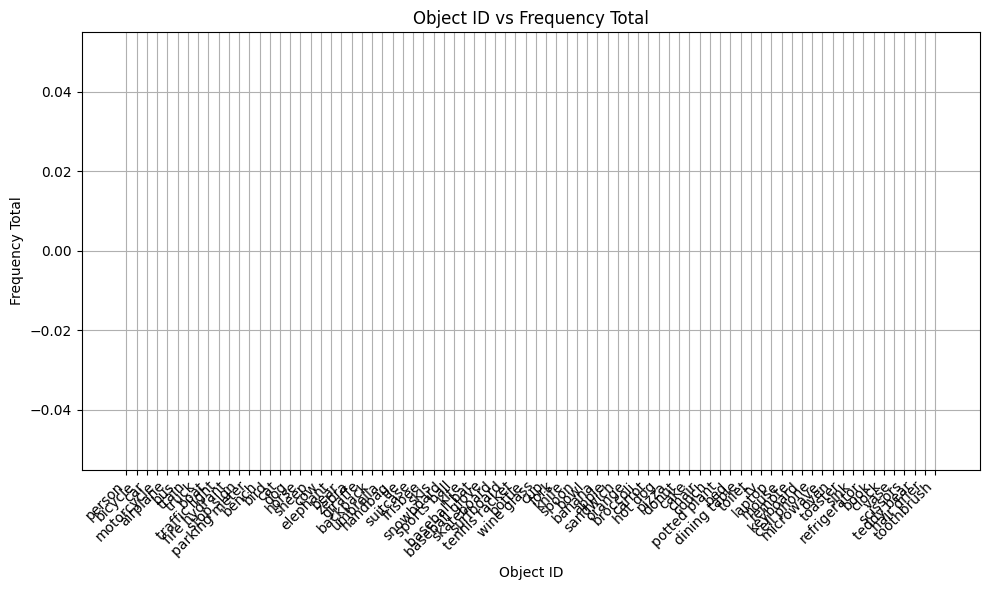

In [11]:
import matplotlib.pyplot as plt


object_ids = list(class_ids_hate_weight.keys())
obj_names=[]
for elem in object_ids:
    obj_names.append(class_labels[elem])
freq_totals = [entry['freq_total'] for entry in class_ids_hate_weight.values()]

# Plot the graph
temp_obj_names=obj_names
temp_freq_totals=freq_totals
plt.figure(figsize=(10, 6))
plt.bar(obj_names, freq_totals, color='blue')
plt.xlabel('Object ID')
plt.ylabel('Frequency Total')
plt.title('Object ID vs Frequency Total')
plt.xticks(rotation=45, ha='right') 
plt.grid(True)
plt.tight_layout()
plt.show()

### Since Person was a very common entry, it's scale prevented from visualising others so removing it and plotting again

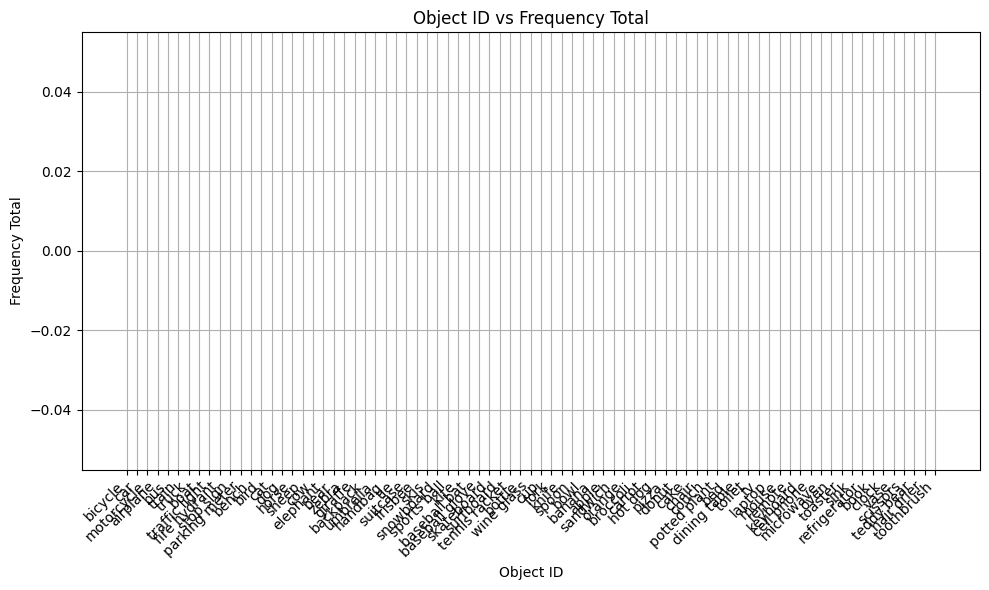

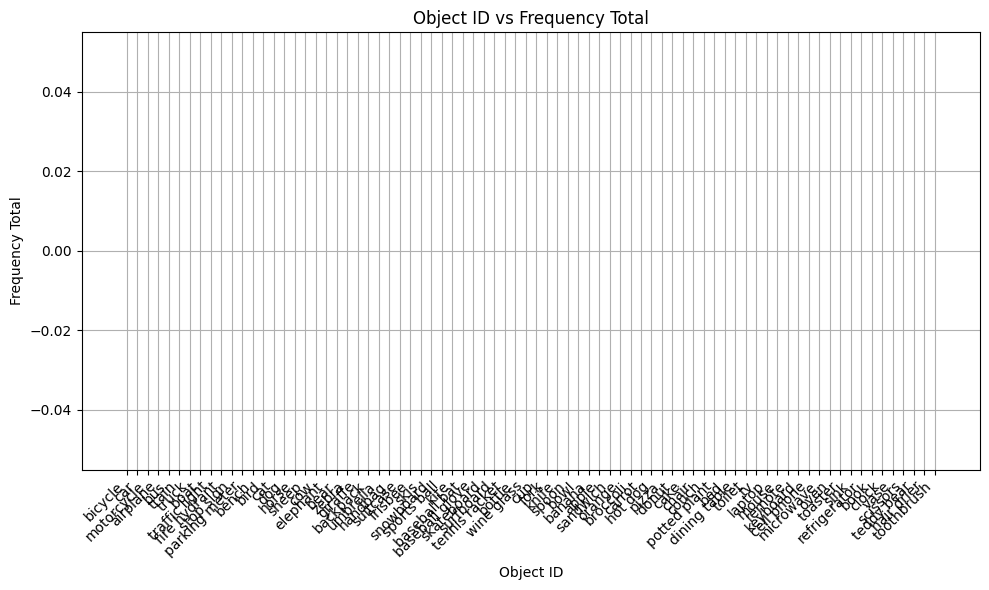

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(obj_names[1:], freq_totals[1:], color='blue')
plt.xlabel('Object ID')
plt.ylabel('Frequency Total')
plt.title('Object ID vs Frequency Total')
plt.xticks(rotation=45, ha='right') 
plt.grid(True)
plt.tight_layout()
plt.show()

# Similar for tie
# print(freq_totals)
# print(obj_names)
if "tie" in obj_names:
    freq_totals.pop(obj_names.index("tie"))
    obj_names.pop(obj_names.index("tie"))
plt.figure(figsize=(10, 6))
plt.bar(obj_names[1:], freq_totals[1:], color='blue')
plt.xlabel('Object ID')
plt.ylabel('Frequency Total')
plt.title('Object ID vs Frequency Total')
plt.xticks(rotation=45, ha='right') 
plt.grid(True)
plt.tight_layout()
plt.show()

### This gives us a clear idea on what objects are very common in memes, if we want we can tabulate the list of words and their frequencies in a table

In [13]:
from tabulate import tabulate

# Combine the two lists into a list of tuples
temp_obj_names.append("tie")
temp_freq_totals.append(1229)
data = list(zip(temp_obj_names, temp_freq_totals))
data = sorted(data, key=lambda x: -x[1])
# Use tabulate to format the data
table = tabulate(data, headers=['Name of Object', 'Frequency'], tablefmt='grid')

print(table)

+------------------+-------------+
| Name of Object   |   Frequency |
+==================+=============+
| tie              |        1229 |
+------------------+-------------+
| person           |           0 |
+------------------+-------------+
| bicycle          |           0 |
+------------------+-------------+
| car              |           0 |
+------------------+-------------+
| motorcycle       |           0 |
+------------------+-------------+
| airplane         |           0 |
+------------------+-------------+
| bus              |           0 |
+------------------+-------------+
| train            |           0 |
+------------------+-------------+
| truck            |           0 |
+------------------+-------------+
| boat             |           0 |
+------------------+-------------+
| traffic light    |           0 |
+------------------+-------------+
| fire hydrant     |           0 |
+------------------+-------------+
| stop sign        |           0 |
+------------------+

### Now demonstrating the same for hateful and good to understand distribution of images across the dataset as good and hateful

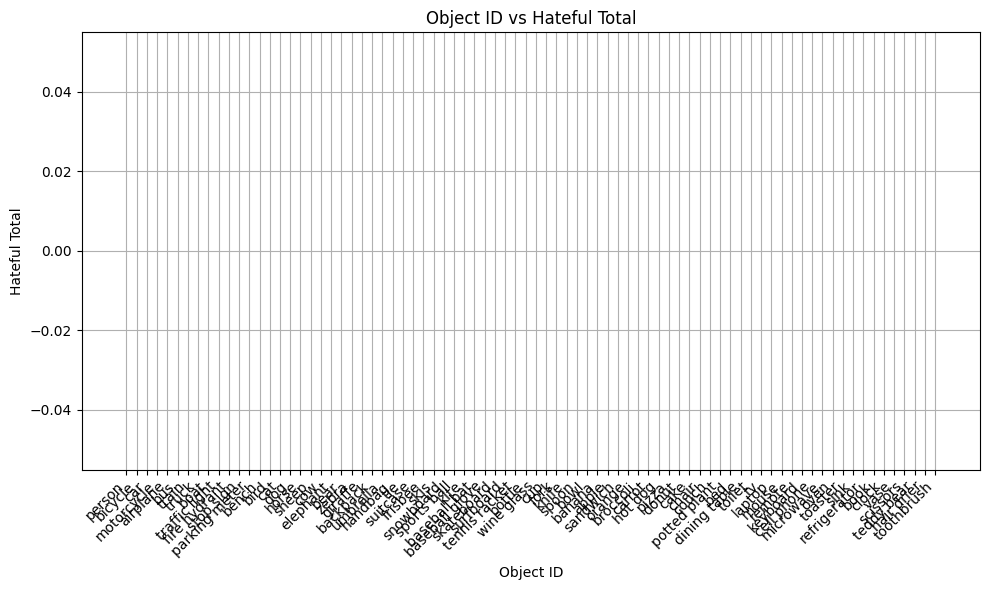

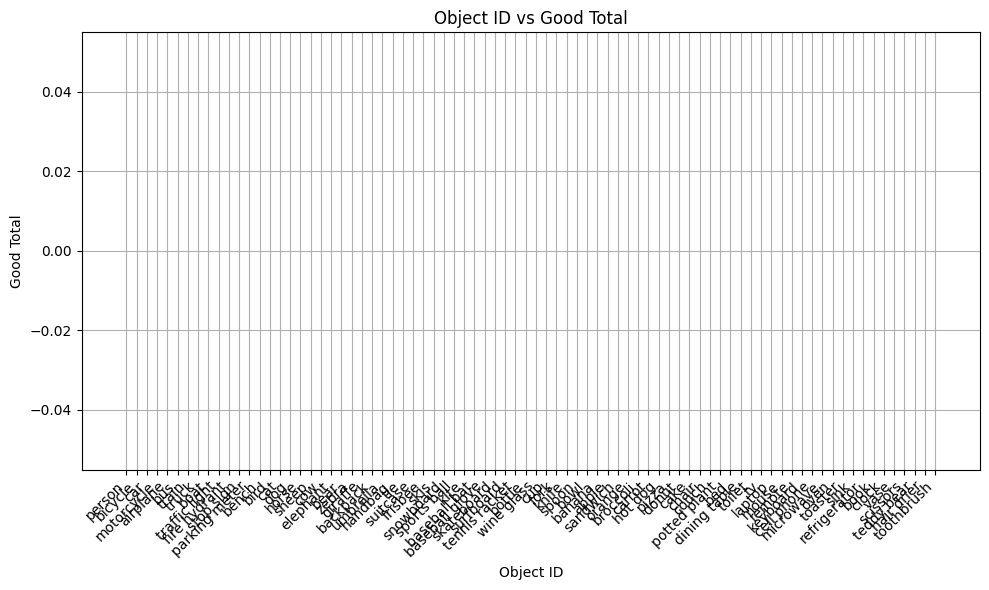

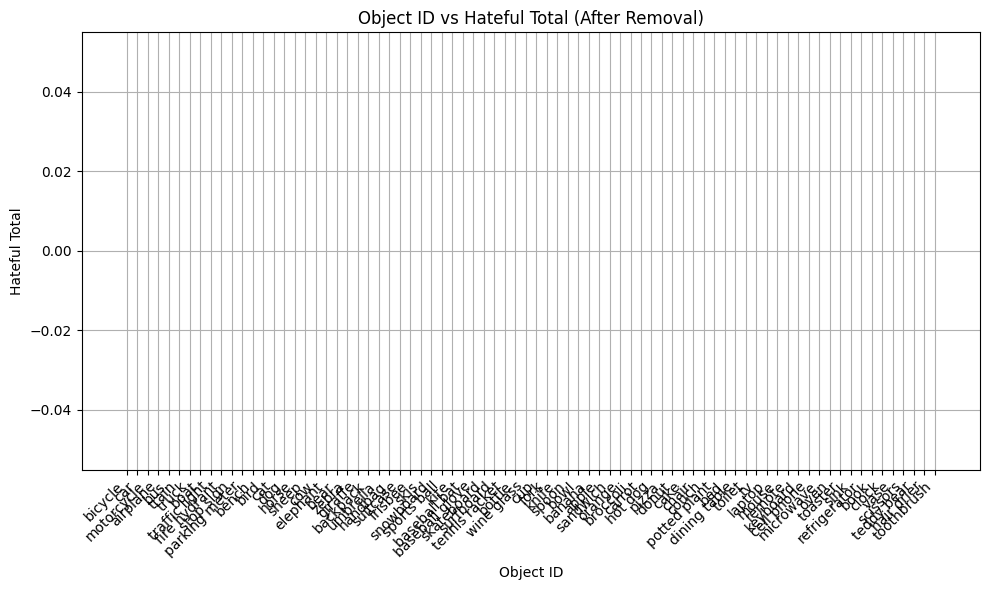

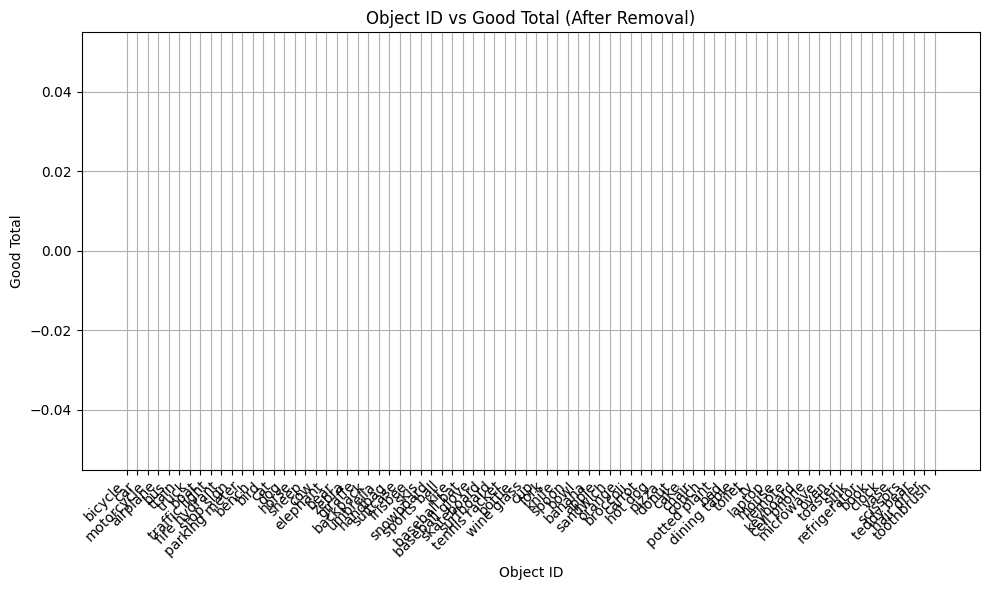

+------------------+-----------------+--------------+
| Name of Object   |   Hateful Total |   Good Total |
+==================+=================+==============+
| bicycle          |               0 |            0 |
+------------------+-----------------+--------------+
| car              |               0 |            0 |
+------------------+-----------------+--------------+
| motorcycle       |               0 |            0 |
+------------------+-----------------+--------------+
| airplane         |               0 |            0 |
+------------------+-----------------+--------------+
| bus              |               0 |            0 |
+------------------+-----------------+--------------+
| train            |               0 |            0 |
+------------------+-----------------+--------------+
| truck            |               0 |            0 |
+------------------+-----------------+--------------+
| boat             |               0 |            0 |
+------------------+--------

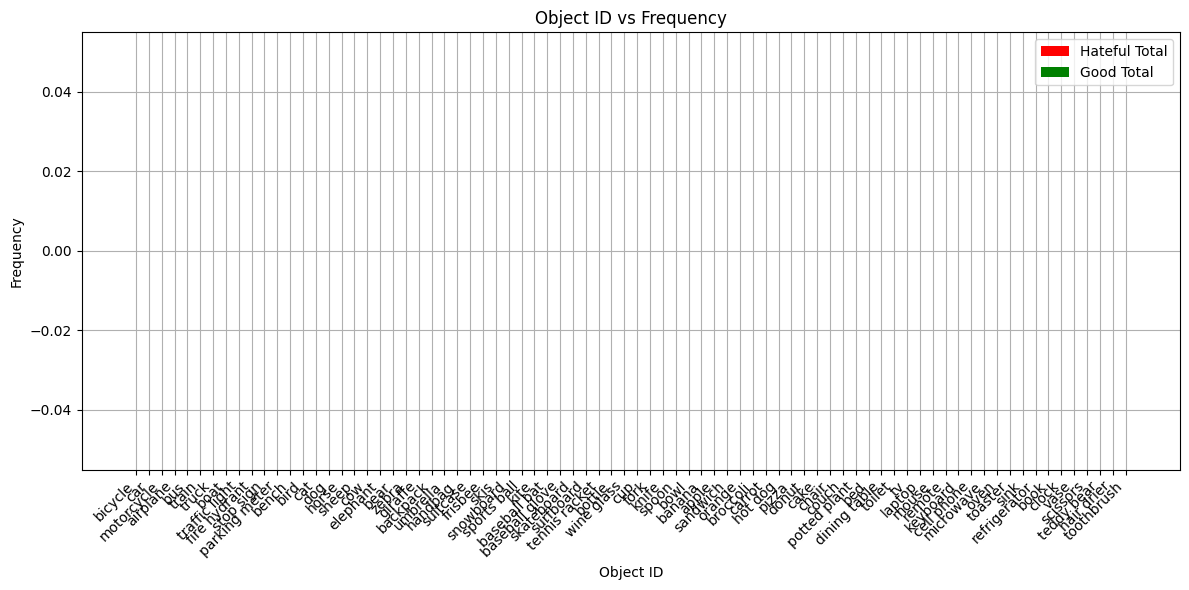

In [14]:
import matplotlib.pyplot as plt
from tabulate import tabulate

object_ids = list(class_ids_hate_weight.keys())
obj_names = [class_labels[elem] for elem in object_ids]
freq_hateful = [entry['hateful_total'] for entry in class_ids_hate_weight.values()]
freq_good = [entry['good_total'] for entry in class_ids_hate_weight.values()]

# Plot the graph for hateful_total
plt.figure(figsize=(10, 6))
plt.bar(obj_names, freq_hateful, color='red')
plt.xlabel('Object ID')
plt.ylabel('Hateful Total')
plt.title('Object ID vs Hateful Total')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the graph for good_total
plt.figure(figsize=(10, 6))
plt.bar(obj_names, freq_good, color='green')
plt.xlabel('Object ID')
plt.ylabel('Good Total')
plt.title('Object ID vs Good Total')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Remove specific entries from the data (e.g., "Person" and "Tie")
obj_names_filtered = [name for name in obj_names if name not in ["person", "tie"]]
freq_hateful_filtered = [freq for name, freq in zip(obj_names, freq_hateful) if name not in ["person", "tie"]]
freq_good_filtered = [freq for name, freq in zip(obj_names, freq_good) if name not in ["person", "tie"]]

# Plot the graph for hateful_total after removing specific entries
plt.figure(figsize=(10, 6))
plt.bar(obj_names_filtered, freq_hateful_filtered, color='red')
plt.xlabel('Object ID')
plt.ylabel('Hateful Total')
plt.title('Object ID vs Hateful Total (After Removal)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the graph for good_total after removing specific entries
plt.figure(figsize=(10, 6))
plt.bar(obj_names_filtered, freq_good_filtered, color='green')
plt.xlabel('Object ID')
plt.ylabel('Good Total')
plt.title('Object ID vs Good Total (After Removal)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Combine the two lists into a list of tuples for tabulation
data = list(zip(obj_names_filtered, freq_hateful_filtered, freq_good_filtered))

# Sort the data based on either hateful_total or good_total
# For example, sort based on hateful_total
data = sorted(data, key=lambda x: -x[1])

# Use tabulate to format the data
table = tabulate(data, headers=['Name of Object', 'Hateful Total', 'Good Total'], tablefmt='grid')

print(table)

import numpy as np
bar_width = 0.35
index = np.arange(len(obj_names_filtered))

plt.figure(figsize=(12, 6))
bar1 = plt.bar(index, freq_hateful_filtered, bar_width, label='Hateful Total', color='red')
bar2 = plt.bar(index + bar_width, freq_good_filtered, bar_width, label='Good Total', color='green')

plt.xlabel('Object ID')
plt.ylabel('Frequency')
plt.title('Object ID vs Frequency')
plt.xticks(index + bar_width / 2, obj_names_filtered, rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We can clearly see which words are more common as hateful and which as good, and thus observe the general distribution of the word

The following part considers code for the classifier in which I use a simple model which is similar to Naive Bayes Classifying model  in implementation to classify a word as hateful or not, technically just counting the frequencies of the word and dividing it by the total number of hateful images (since number of hateful and non-hateful images differs) can give us a general idea of which words occur more but it is better to use the Naive Bayes Method because it can then be used to determine if a bunch of objects collectively are hateful or not, which can help in classifying images further

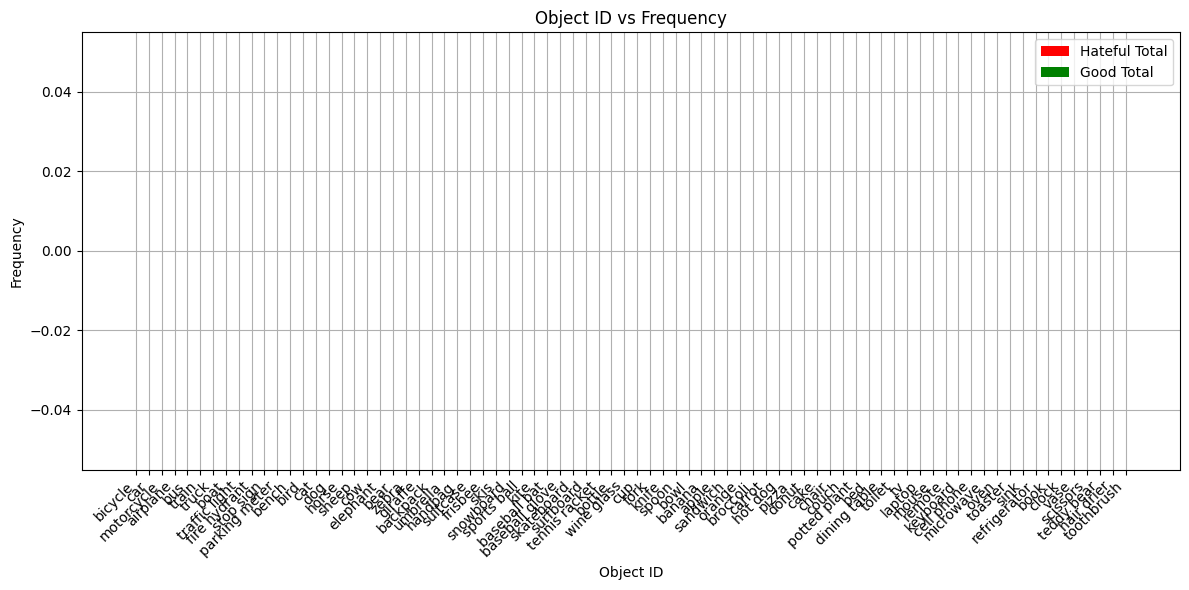

In [15]:
# Dividing frequencies by number of total images of that kind  to get a more accurate plot for hateful non-hateful
import numpy as np
bar_width = 0.35
index = np.arange(len(obj_names_filtered))

plt.figure(figsize=(12, 6))
hateful_obj_freq_true=[elem/3050 for elem in freq_hateful]
good_obj_freq_true=[elem/5450 for elem in freq_good]
bar1 = plt.bar(index, [elem/3050 for elem in freq_hateful_filtered], bar_width, label='Hateful Total', color='red')
bar2 = plt.bar(index + bar_width, [elem /5450 for elem in freq_good_filtered], bar_width, label='Good Total', color='green')

plt.xlabel('Object ID')
plt.ylabel('Frequency')
plt.title('Object ID vs Frequency')
plt.xticks(index + bar_width / 2, obj_names_filtered, rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
for index,(hate,good) in enumerate(zip(hateful_obj_freq_true,good_obj_freq_true)):
    if (hate>good):
        print(obj_names[index])
        
# These represent all hateful objects when considered normally

Note for the Naive Bayes inspired model I also decided to factor in confidences of the prediciton of the object while computing, that helps again better classify the objects

In [17]:
import json
dictionary={}
hateful_or_not={}
count=0
with open ("../data/train.jsonl",'r') as f:
    for line in f:
        elem=json.loads(line)
        if (int(elem['label'])==0):
            hateful_or_not[int(elem['id'])]=0
        else:
            hateful_or_not[int(elem['id'])]=1
            count+=1
print(count)
probab_hateful=count/len(hateful_or_not)
words_object_hateful={}
words_object_normal={}
with open("object_details.json", 'r') as f:
    dictionary=json.load(f)
    for (image_id,elem) in dictionary.items():
        # print(sentence)
        for inndexing,id in enumerate(elem['class_ids']):
            # if (id==11):
                # print(image_id)
            if (hateful_or_not[int(image_id)]==0):
                if id in words_object_normal:
                    words_object_normal[id]+=elem['confs'][inndexing]
                else:
                    words_object_normal[id]=elem['confs'][inndexing]
            else:
                if id in words_object_hateful:
                    words_object_hateful[id]+=elem['confs'][inndexing]
                else:
                    words_object_hateful[id]=elem['confs'][inndexing]


print(words_object_hateful)
print(words_object_normal)
# again factoring the fact that hateful images are less
normalized_hateful = {word: count / 3050 for word, count in words_object_hateful.items()}
normalized_normal = {word: count / 5450 for word, count in words_object_normal.items()}
print(normalized_hateful)
print(normalized_normal)
with open("words_object_hateful.json", 'w') as f:
    json.dump(normalized_hateful,f)
with open("words_object_normal.json", 'w') as f:
    json.dump(normalized_normal,f)

FileNotFoundError: [Errno 2] No such file or directory: '../data/train.jsonl'

In [ ]:
probab_hateful=1/2
names_id={}
for elem in model.names.items():
    names_id[elem[1]]=elem[0]
    id_names[elem[0]]=elem[1]
id_names={}
positive_negative_weight=[]
for name in obj_names:
    temp_weight=0
    if names_id[name] in normalized_hateful:
        temp_weight-=normalized_hateful[names_id[name]]
    if names_id[name] in normalized_normal:
        temp_weight+=normalized_normal[names_id[name]]
    positive_negative_weight.append(temp_weight)
    
print(positive_negative_weight)


# The below code is of Naive Bayes Classifier that I was using for the similar result and I compared both results and went with these

# import numpy as np

# class NaiveBayesClassifier:
#     def __init__(self):
#         self.class_prior = {}
#         self.word_likelihoods = {}

#     def train(self, word_counts, hateful_dict, normal_dict):
#         # for val in hatef
#         total_hateful=0
#         total_normal=0
#         for val in hateful_dict.values():
#             total_hateful+=val
#         for val in normal_dict.values():
#             total_normal+=val
#         # total_hateful = sum(hateful_counts)
#         # total_normal = sum(normal_counts)
#         total_examples = total_hateful + total_normal
        
#         # self.class_prior[1] = total_hateful / total_examples
#         # self.class_prior[0] = total_normal / total_examples
#         self.class_prior[1] = probab_hateful
#         self.class_prior[0] = 1 - probab_hateful
        
#         for word in word_counts:
#             hateful_count=0
#             normal_count=0
#             if (word in hateful_dict):
#                 hateful_count=int(hateful_dict[word])
#             if (word in normal_dict):
#                 normal_count=int(normal_dict[word])
#             prob_hateful = (hateful_count + 1) / (total_hateful + len(word_counts))
#             prob_normal = (normal_count + 1) / (total_normal + len(word_counts))
#             self.word_likelihoods[word] = (prob_hateful, prob_normal)

#     def predict(self, X_test):
#         predictions = []
#         for text in X_test:
#             prob_hateful = np.log(0.9996560693296879*self.class_prior[1])
#             prob_normal = np.log(self.class_prior[0])
#             for word, count in text.items():
#                 if word in self.word_likelihoods:
#                     prob_hateful += count * np.log(self.word_likelihoods[word][0])
#                     prob_normal += count * np.log(self.word_likelihoods[word][1])
#                     # print(prob_hateful)
#                     # print(prob_normal)
#             predictions.append(1 if prob_hateful > prob_normal else 0)
#         return predictions

# # Example usage:
# # print(prob_hateful)
# # word_counts = ["love", "hate", "awesome", "stupid"]
# # hateful_counts = [1, 3, 0, 1]
# # normal_counts = [2, 0, 1, 2]
# word_counts=[]
# for word,count in words_object_hateful.items():
#     word_counts.append(word)
# for word,count in words_object_normal.items():
#     if word not in word_counts:
#         word_counts.append(word)


# classifier = NaiveBayesClassifier()
# classifier.train(word_counts,words_object_hateful, words_object_normal)

# classifier = NaiveBayesClassifier()
# classifier.train(word_counts, words_object_hateful, words_object_normal)

# # X_test = [{11: 0}, { 1:0}]
# with open ("object_details_test.json") as f:
#     object_details_test=json.load(f)
# X_test=[]
# answers=[]
# for image_id,elem in object_details_test.items():
#     for index,id in enumerate(elem['class_ids']):
#         temp_dict={id:elem['confs'][index]}
#     X_test.append(temp_dict)
#     answers.append(elem['label'])

# from decimal import Decimal

# low = Decimal('0.7')
# high = Decimal('1.5')
# precision = Decimal('1e-6')

# while high - low >= precision:
#     mid1 = low + (high - low) / Decimal('3')
#     mid2 = high - (high - low) / Decimal('3')
    
#     predictions1 = classifier.predict(X_test, float(mid1))
#     predictions2 = classifier.predict(X_test, float(mid2))
    
#     count1 = sum(1 for answer, predict in zip(answers, predictions1) if answer == predict)
#     count2 = sum(1 for answer, predict in zip(answers, predictions2) if answer == predict)
    
#     if count1 > count2:
#         high = mid2
#     else:
#         low = mid1

# best_factor = (low + high) / Decimal('2')

# print("Best factor:", float(best_factor))
# print("Max count:", max(count1, count2))

# low = 0.7
# high = 1.3
# max_count = 0
# best_factor = low

# while high - low >= 1e-6:
#     mid = (low + high) / 2
#     predictions = classifier.predict(X_test, mid)
#     count = 0
#     count2 = 0
#     for answer, predict in zip(answers, predictions):
#         if answer == predict:
#             if answer == 0:
#                 count += 1
#             else:
#                 count2 += 1
#     total_count = count + count2
#     if total_count > max_count:
#         max_count = total_count
#         best_factor = mid
#     if count > count2:
#         low = mid
#     else:
#         high = mid

# print("Best factor:", best_factor)
# print("Max count:", max_count)


# predictions = classifier.predict(X_test)
# print(predictions)  # Output: [1, 0] indicating hateful and non-hateful respectively
# count=0
# count2=0
# for answer,predict in zip(answers,predictions):
#     if (answer==predict):
#         if (answer==0):
#             count+=1
#         else:
#             count2+=1
#         # print("Haash")
#         # count+=1
# print(count,count2)


[-0.07548432194768884, 0.0020532019015702474, 0.011424585553394581, 0.0013163071579459125, 0.00014326449641071217, 9.834730960423107e-05, 0.00083622184655311, 0.00033457290536390363, 0.0008369182104238952, 0.0007043515904395451, 0.0004500974537035741, -0.0002304201413678269, 7.716026570065828e-05, -0.0020649725830739632, 0.005818305786148302, 0.010168667584007748, 0.003031574206381636, 0.0019299094767333122, 0.0421497507008561, 0.0021741454238048226, 0.0005754545719610298, 0.006613075794680959, 0.0001522347749238768, -0.0001808603669776291, 0.0005267435825934245, 0.00047250879924267547, 0.0008695369706976444, 0.02646517913347618, 0.0011848350332489335, -0.0005441594346158756, 0.00024536838135623916, 0.00013651598860651304, 0.000144948321619434, 0.0008650538135711585, -0.0021838470338286986, 5.934409332160654e-05, 0.0012438951719791517, 0.0008763745803190437, 0.00010994787161682656, 0.006665161142386536, 0.004482397490792713, 0.010339331816579901, 0.0009804620027793118, 0.00062163752637

In [ ]:
# Testing the code on dev dataset
image_answers=[]
with open ("../data/dev.jsonl") as f:
    for line in f:
        elem = json.loads(line)
        if elem['label']==0:
            image_answers.append(0)
        else:
            image_answers.append(1)
predictions_test=[]
with open ("object_details_test.json") as f:
    dicti=json.load(f)
    for elem in dicti:
        ans=0
        for classy in elem['class_ids']:
            ans+=id_names[classy]*elem['confs']
        if (ans<0):
            predictions_test.append(1)
        else:
            predictions_test.append(0)
count=0
count2=0
for answer,prediction in zip(image_answers,predictions_test):
    if (answer==prediction):
        if (answer==0):
            count+=1
        else:
            count2+=1
            
print(count,count2)